In [62]:
import numpy as np
targetPosition=[2.2,4.0,6.0]
originPosition=[0.0,0.0,0.0]
orientationAngleLimit=0.5
constraintType = ["ball","ball","hinge","ball","ball","ball","ball","ball","ball","ball","ball","ball"
                 ,"ball","ball","ball","ball","ball"]

In [63]:
import math  
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from pycg3d.cg3d_point import CG3dPoint
from pycg3d.cg3d_vector import CG3dVector
from pycg3d import utils
from pycg3d.cg3d_plane import CG3dPlanePN
import Constraints as CF
from draw import draw

class FABRIK:
    
    def __init__(self,joints,target,origin,orientation,length,Theta,constraintType):
        self.n=len(joints)
        self.joints = joints
        self.orientation = orientation
        #self.constraintType = constraintType
        self.rightArmIndex = [0,1,2,3,4]
        self.leftArmIndex = [0,5,6,7,8]
        self.upperChain = [0,1,5,0]
        self.lowerChain = [0,9,10,0]
        self.rightLeg = [13,12,11,9]
        self.leftLeg = [16,15,14,10]
        
        self.Theta=Theta
        self.constraintType=constraintType
        self.firstPos = length
        self.tolerance=0.01
        self.target=target
    
    def distanceCalc(self,i,j):
        iPoint=CG3dPoint(i[0],i[1],i[2])
        jPoint=CG3dPoint(j[0],j[1],j[2])

        return (utils.distance(iPoint,jPoint))
    
    def findingTargetPos(self):
        rightUpperBody= self.distanceCalc(self.firstPos[0],self.target)
        leftUpperBody= self.distanceCalc(self.firstPos[0],self.target)     

        # ON THE RIGHT SIDE OR LEFT
        if rightUpperBody < leftUpperBody:
            return "right"
        if rightUpperBody > leftUpperBody:
            return "left"

    def forwardARM(self,ArmIndex):
        # set end effector as target
        n = len(ArmIndex)
        self.joints[ArmIndex[n-1]] = self.target;
        for i in range(n-2,-1,-1):
            r = self.distanceCalc(self.joints[ArmIndex[i]],self.joints[ArmIndex[i+1]])
            landa =  self.distanceCalc(self.firstPos[ArmIndex[i]],self.firstPos[ArmIndex[i+1]])/r
            # find new joint position
            pos=(1-landa)*self.joints[ArmIndex[i+1]]+landa*self.joints[ArmIndex[i]]
            constraintReturn = CF.constraintsFunction.constraint(self.joints,i,self.Theta[ArmIndex[i]],self.constraintType[ArmIndex[i]],self.target)
            if constraintReturn[0] == 0:
                self.joints[ArmIndex[i]]=pos
            else:
                for j in range(3):
                    self.joints[ArmIndex[i]][j]=constraintReturn[j]
    def updateUpperChain(self,targetPos):
        translatedDistance = self.distanceCalc(self.joints[self.upperChain[0]], self.firstPos[self.upperChain[0]])
        if targetPos =="right":
            self.joints[self.upperChain[2]] = self.firstPos[self.upperChain[2]]+ translatedDistance
            for p in range(2,len(self.leftArmIndex)):
                self.joints[self.leftArmIndex[p]] = self.firstPos[self.leftArmIndex[p]]+ translatedDistance  
        else:
            self.joints[self.upperChain[1]] = self.firstPos[self.upperChain[1]]+ translatedDistance
            for p in range(2,len(self.rightArmIndex)):
                self.joints[self.rightArmIndex[p]] = self.firstPos[self.rightArmIndex[p]]+ translatedDistance
    def updateLowerChainF(self):
        translatedDistance = self.distanceCalc(self.joints[self.lowerChain[0]], self.firstPos[self.lowerChain[0]])
        self.joints[self.lowerChain[1]] = self.firstPos[self.lowerChain[1]]+ translatedDistance  
        self.joints[self.lowerChain[2]] = self.firstPos[self.lowerChain[2]]+ translatedDistance
    def updateLowerChainB(self):
        translatedDistance = self.distanceCalc(self.joints[self.lowerChain[1]], self.firstPos[self.lowerChain[1]])
        self.joints[self.lowerChain[0]] = self.firstPos[self.lowerChain[0]]+ translatedDistance 
    def forwardLeg(self):
         # set end effector of leg as target
        n = len(self.rightLeg)
        for i in range(n-2,-1,-1):
            # Right Leg
            r = self.distanceCalc(self.joints[self.rightLeg[i]],self.joints[self.rightLeg[i+1]]) 
            landa = self.distanceCalc(self.firstPos[self.rightLeg[i]],self.firstPos[self.rightLeg[i+1]])/r
            # find new joint position
            pos=(1-landa)*self.joints[self.rightLeg[i+1]]+landa*self.joints[self.rightLeg[i]]
            constraintReturn = CF.constraintsFunction.constraint(self.joints,i,self.Theta[self.rightLeg[i]],self.constraintType[self.rightLeg[i]],self.target)
            if constraintReturn[0] == 0:
                self.joints[self.rightLeg[i]]=pos
            else:
                for j in range(3):
                    self.joints[self.rightLeg[i]][j]=constraintReturn[j]
    
            #Left leg
            r = self.distanceCalc(self.joints[self.leftLeg[i]],self.joints[self.leftLeg[i+1]])
            landa = self.distanceCalc(self.firstPos[self.leftLeg[i]],self.firstPos[self.leftLeg[i+1]])/r
            # find new joint position
            pos=(1-landa)*self.joints[self.leftLeg[i+1]]+landa*self.joints[self.leftLeg[i]]
            
            constraintReturn = CF.constraintsFunction.constraint(self.joints,i,self.Theta[self.leftLeg[i]],self.constraintType[self.leftLeg[i]],self.target)
            if constraintReturn[0] == 0:
                self.joints[self.leftLeg[i]]=pos
            else:
                for j in range(3):
                    self.joints[self.leftLeg[i]][j] = constraintReturn[j]
    
    
    def backwardARM(self,ArmIndex):
        # set root as initial position
        n = len(ArmIndex)
        for i in range(1,n):
            r = self.distanceCalc(self.joints[ArmIndex[i]],self.joints[ArmIndex[i-1]])
            landa = self.distanceCalc(self.firstPos[ArmIndex[i]],self.firstPos[ArmIndex[i-1]])/r
            # find new joint position
            pos=(1-landa)*self.joints[ArmIndex[i-1]]+landa*self.joints[ArmIndex[i]]
            self.joints[ArmIndex[i]]=pos;
    def backwardLeg(self):
        # set root as initial position
        self.joints[self.rightLeg[0]] = self.firstPos[self.rightLeg[0]]
        self.joints[self.leftLeg[0]] = self.firstPos[self.leftLeg[0]]
        n = len(self.rightLeg)
        for i in range(1,n):
            #for Right leg
            r = self.distanceCalc(self.joints[self.rightLeg[i]],self.joints[self.rightLeg[i-1]])
            landa = self.distanceCalc(self.firstPos[self.rightLeg[i]],self.firstPos[self.rightLeg[i-1]])/r
            # find new joint position
            pos=(1-landa)*self.joints[self.rightLeg[i-1]]+landa*self.joints[self.rightLeg[i]]
            self.joints[self.rightLeg[i]]=pos;
         #for left leg
            r = self.distanceCalc(self.joints[self.leftLeg[i]],self.joints[self.leftLeg[i-1]])
            landa = self.distanceCalc(self.firstPos[self.leftLeg[i]],self.firstPos[self.leftLeg[i-1]])/r
            # find new joint position
            pos=(1-landa)*self.joints[self.leftLeg[i-1]]+landa*self.joints[self.leftLeg[i]]
            self.joints[self.leftLeg[i]]=pos;
    def solve(self):
        sumL = 0
        targetPos = self.findingTargetPos()
        if targetPos == "right":
            #arm length
            for i in range(len(self.rightArmIndex)-1):
                sumL = sumL + self.distanceCalc(self.firstPos[self.rightArmIndex[i]],self.firstPos[self.rightArmIndex[i+1]])
            #chain length
            sumL = sumL + self.distanceCalc(self.firstPos[0],self.firstPos[self.rightLeg[len(self.rightLeg)-1]])
            #Leg length
            for i in range(len(self.rightLeg)-1):
                sumL = sumL + self.distanceCalc(self.firstPos[self.rightLeg[i]],self.firstPos[self.rightLeg[i+1]])
            if sumL < self.distanceCalc(self.firstPos[self.rightLeg[0]],self.target):
                print("target is out of reach!!!!!!!")
                return
        else:
            #arm length
            for i in range(len(self.leftArmIndex)-1):
                sumL = sumL + self.distanceCalc(self.firstPos[self.leftArmIndex[i]],self.firstPos[self.leftArmIndex[i+1]])
            #chain length
            sumL = sumL + self.distanceCalc(self.firstPos[0],self.firstPos[self.leftLeg[len(self.leftLeg)-1]])
            #Leg length
            for i in range(len(self.leftLeg)-1):
                sumL = sumL + self.distanceCalc(self.firstPos[self.leftLeg[i]],self.firstPos[self.leftLeg[i+1]])
            if sumL < self.distanceCalc(self.firstPos[self.leftLeg[0]],self.target):
                print("target is out of reach!!!!!!!")
                return
        for p in range (0,len(self.joints)):
            for q in range(0,4):
                if self.Theta[p][q]>=2:
                    print("one of joints limit is out of range!!!")
                    return
                
        # target is in reach
            bcount=0;
            if targetPos == "right":
                n = len(self.rightArmIndex)
                dif = self.distanceCalc(self.joints[self.rightArmIndex[n-1]],self.target)
            else: 
                n = len(self.leftArmIndex)
                dif = self.distanceCalc(self.joints[self.leftArmIndex[n-1]],self.target)
            
            
            while dif > self.tolerance:
                if targetPos == "right":
                    self.forwardARM(self.rightArmIndex)
                else: 
                    self.forwardARM(self.leftArmIndex)
                self.updateUpperChain(targetPos)
                self.updateLowerChainF()
                self.forwardLeg()
                
                self.backwardLeg()
                self.updateLowerChainB()
                if targetPos == "right":
                    self.backwardARM(self.rightArmIndex) 
                else:
                    self.backwardARM(self.leftArmIndex)   
                self.updateUpperChain(targetPos)
                if targetPos == "right":
                    dif = self.distanceCalc(self.joints[self.rightArmIndex[n-1]],self.target)
                else:
                    dif = self.distanceCalc(self.joints[self.leftArmIndex[n-1]],self.target)
                bcount=bcount+1
                if bcount>10:
                     break
                
        draw(self.joints,self.target,np.loadtxt("length.txt"),self.rightArmIndex,self.leftArmIndex,self.upperChain,self.lowerChain,self.rightLeg,self.leftLeg)

In [64]:
manipulator = FABRIK(np.loadtxt("joints.txt"),targetPosition,originPosition,orientationAngleLimit,np.loadtxt("length.txt"),np.loadtxt("Theta.txt"),constraintType)

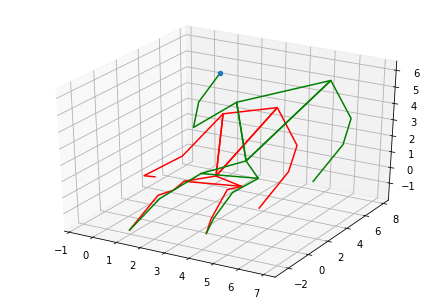

In [65]:
manipulator.solve()